# Radiometric Dating: Uncovering the Age of the Solar System

### Introduction:

Many aspects of the origin and evolution of the Solar System remains unknown to sciences. One thing, however, that is not unknown is the age of the Solar System. In fact, the age of the Solar System has been constrained with a remarkable precision. The science that led to this discovery was not in the field of astronomy, however, but rather geochemistry. Radiometric dating, to be specific, is the method that was used to uncover the age of the Solar System, through the dating of rocks that formed before even the planets did, out of the same material as the Sun [1]. These rocks are known as chondrites. A plot of chondrite composition compared to solar composition is shown below [2]:

<img src="solar_abundances.png" alt="Chondrite vs Solar Composition" width="300"/>

Because chondrites formed during the birth of the Solar System, applying radiometric dating techniques to them provides the age of the Solar System itself. Specficially, Pb-Pb dating is used to do this. $^{238}U$ & $^{235}U$ present in the chondrite when it formed decay into $^{206}P$ & $^{207}P$ respectively, and by plotting present day $^{206}P$ against $^{207}P$ as ratios over the stable $^{204}P$, an isochron is formed whose slope reveals the age of the rock [3]. For this project, I will explore chondrite origin, radioactive decay, and isochron plotting in order to contrain the age of Solar System. I will do this by first understanding where meteorites are found and the implications of the results, then looking into the math that explains the decay of uranium isotopes into lead, and lastly by plotting the isochron of chondrites and conducting error analaysis in order to produce a final age result. For meteorite find locations, I will use a dataset from NASA which includes data from 45,000+ meteorites [4], including the longitude and latitude at which they were found. I will plot these coordinates using cartopy and analyze overall trends in the map. For the radioactive decay science portion of the project, I will explore the equations that explain the decay and plot a visualization of the process. Lastly, I will use a dataset of chondrite Pb ratios obtained from an paper titled "Variable Tl, Pb, and Cd concentrations and isotope compositions of enstatite and ordinary chondrites—Evidence for volatile element mobilization and decay of extinct $^{205}Pb$" [5] to obtain the slope of the isochron, which I will then use to find the age of the chondrites.

The first thing I will do is import packages/libraries that are necessary to carry out the analysis I want to perform:

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import fsolve
from scipy import stats
import scipy as scipy
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader

Below, I loaded in the NASA metoerite data and plotted the location of where metoerites were found using their coordinates.

In [13]:
chondrite_locations=pd.read_csv("data/meteorite-landings.csv")
chondrite_locations.head()

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


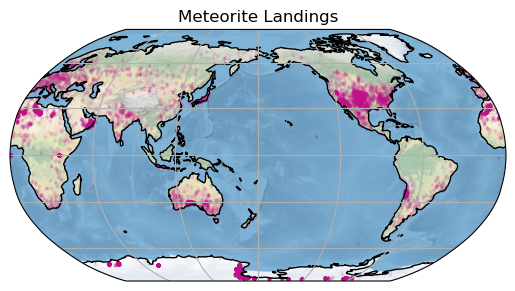

In [14]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.set_global()
plt.scatter(chondrite_locations["reclong"], chondrite_locations["reclat"], transform=ccrs.PlateCarree(), s=0.6, alpha=0.1, color="#be1088", marker="s")
ax.coastlines()
ax.stock_img()
ax.gridlines()
plt.title('Meteorite Landings')    
plt.show()

The above map shows that most meteorites are found in the United States, Europe, the Sahara desert, the Great Victoria Desert, and Antarctica. The idea of analyzing chondrite data as a path to constraining the age of the Solar System depends on the assumption that that chondrites that formed early in the formation of the Solar system fall onto Earth. However, if this were true, one would espect the distribution of chondrites to be evenly spaced around the Earth, which is not what is seen in the map above. It is therefore improtant to understand why this is the case. From the map, it can be seen that places where chondrites are found are one of two places: 
1) Locations where there are more resources for scientific research to look for meteorites, such as the United States and Europe.
2) Locations with landscapes that make it easy to find meteorites, such as deserts.

Although the map of meteorite findings shows a bias towards certian locations, this bias is not the result of the rocks themselves but rather the actual process of finding them. With this understanding, I will zoom in to the actual comoposition of the chondrites. As mentioned previously, the decay of uranium isotopes into lead isotopes is what is used to constrain the age of chondrites. This decay can be modeled with the following equation:
$$
N(t)=N_0 e^{-\lambda t}
$$
where $N(t)$ is the number of parent element atoms at a given time, $N_0$ is the initial number of parent element atoms, and $\lambda$ is the decay constant associated with how long it takes the parent element to decay. The decay of $^{238}U$ into $^{206}P$ has a decay constant of 0.155125 Ga, and the decay of $^{235}U$ into $^{207}P$ has a decay constant of 0.98571 Ga [5]. Plotting the decay of both these paths using an arbitratily chosen initial population of 1000 atoms produces the following plot:

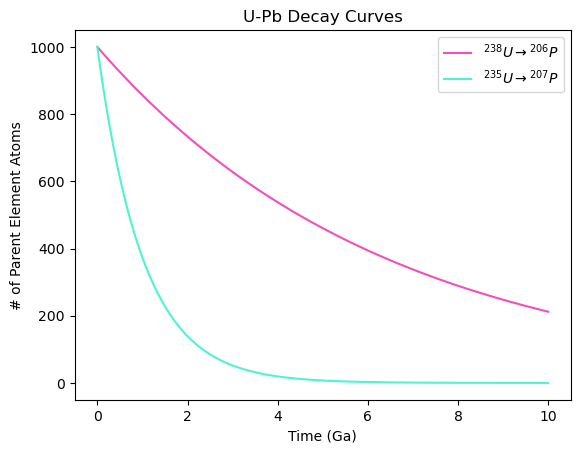

In [15]:
lambda1=0.155125 #Ga
lambda2=0.98571 #Ga
initial=1000
t=np.linspace(0,10,1000)
decay1=initial*np.exp(-lambda1*t)
decay2=initial*np.exp(-lambda2*t)
plt.plot(t, decay1, label=r"$^{238}U \rightarrow ^{206}P$", color="#f44ebb")
plt.plot(t, decay2, label=r"$^{235}U \rightarrow ^{207}P$", color="#4ef4d1")
plt.title("U-Pb Decay Curves")
plt.legend()
plt.xlabel("Time (Ga)")
plt.ylabel("# of Parent Element Atoms")
plt.show()

With this understanding of radioactive decay established, I will load in the data from Palk et al. 2018 [5] to preform the anlaysis of the isotope ratios. I will first filter out data that is not a number and drop any rows that contain a NaN in the columns I am interested in. These columns are the ones that contain $^{206}P/^{204}P$ and $^{207}P/^{204}P$ ratios, along with their errors, titled "2SE" and "2SE.1", which I will rename to show with measuremenet they are the error of. I will also isolate these columns, along with the column that contains the type of chondrite, as they are the only ones I will use for the rest of the analsysis.

In [16]:
chondrite_data=pd.read_excel("data/chondrite_data.xlsx")
chondrite_data["206Pb/204Pb"] = pd.to_numeric(chondrite_data["206Pb/204Pb"], errors='coerce')
chondrite_data["207Pb/204Pb"] = pd.to_numeric(chondrite_data["207Pb/204Pb"], errors='coerce')
chondrite_data["2SE"] = pd.to_numeric(chondrite_data["2SE"], errors='coerce')
chondrite_data["2SE.1"] = pd.to_numeric(chondrite_data["2SE.1"], errors='coerce')
chondrite_data = chondrite_data.dropna(subset=["206Pb/204Pb", "207Pb/204Pb", "2SE", "2SE.1"])
chondrite_data=chondrite_data.loc[:,["Class","206Pb/204Pb", "207Pb/204Pb", "2SE", "2SE.1"]]
chondrite_data=chondrite_data.rename(columns={"2SE":"206_err"})
chondrite_data=chondrite_data.rename(columns={"2SE.1":"207_err"})
chondrite_data.head()

,Class,206Pb/204Pb,207Pb/204Pb,206_err,207_err
0,EH,10.336,10.972,0.002,0.001
1,EH,16.625,14.794,0.001,0.001
2,EL,9.584,10.480,0.001,0.001
3,EL,9.609,10.496,0.001,0.001
5,EL,10.976,11.339,0.002,0.001


When $^{206}P/^{204}P$ and $^{207}P/^{204}P$ are plotted against each other, they for a line. This line has a slope which can be related to the age of the sample/s through the following equation [6][5]:
$$
m=\frac{1}{137}\frac{e^{{\lambda}_{235} t-1}}{e^{{\lambda}_{238} t-1}}
$$
Therefore, in order to constrain the age of the chondrites, I first must find the slope of the line formed by $^{206}P/^{204}P$ and $^{207}P/^{204}P$. To do this, I will preform a linear regression to create a best fit line of the data, which I will then use the stats.lingress() function to find the value of the slope, along with its error and the r and p value of the data. I will also plot the data with the error and best fit line. The different colors of data points correspond to different types of chondrites.

In [17]:
isotope_model =  LinearRegression().fit(chondrite_data[["206Pb/204Pb"]], chondrite_data["207Pb/204Pb"])
y_pred = isotope_model.predict(chondrite_data[["206Pb/204Pb"]])

m, intercept, r, p, m_err = stats.linregress(chondrite_data["206Pb/204Pb"], chondrite_data["207Pb/204Pb"])
print(f"Using the stats linregress function, the slope is {m:.2f}, the error on the slope is {m_err:.7f}, the r-value is {r:.2f}, and the p-value is {p:.2f}.")

Using the stats linregress function, the slope is 0.61, the error on the slope is 0.0055897, the r-value is 1.00, and the p-value is 0.00.


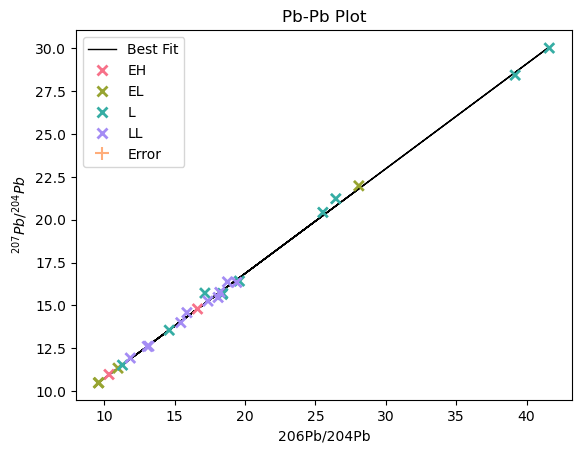

In [18]:
plt.figure()
plt.plot(chondrite_data["206Pb/204Pb"], y_pred, label="Best Fit", color="black", linewidth=1, zorder=2)
sns.scatterplot(x=chondrite_data["206Pb/204Pb"], y=chondrite_data["207Pb/204Pb"], marker="x", hue=chondrite_data["Class"], s=50, linewidth=2, palette="husl", zorder=3)
plt.errorbar(chondrite_data["206Pb/204Pb"], chondrite_data["207Pb/204Pb"], yerr=chondrite_data['207_err']/2, xerr=chondrite_data['206_err']/2, color="#ffad7a", linestyle="none", label="Error", zorder=1)
plt.ylabel(r"$^{207}Pb/^{204}Pb$")
plt.title(r"Pb-Pb Plot")
plt.legend()
plt.show()

Next, I will use fsolve() to solve for the age based on the slope that was calculated above.

In [19]:
#calculating time based on slope
def decay(t, m, lambda1, lambda2):
    return (1/137.88)*((np.exp(lambda2*t) - 1)/(np.exp(lambda1*t) - 1)) - m #137.88 obtained from https://ui.adsabs.harvard.edu/abs/2018M%26PS...53..167P/abstract, equation from https://www2.tulane.edu/~sanelson/eens212/radiometric_dating.htm
guess = 4.5
age = fsolve(decay, guess, args=(m, lambda1, lambda2))

However, it is also important to recognize that there is error in the time calculation due to error in the original isotope ratio measurements. In order to calculate this error, I will use the Monte Carlo method to propogate the original error. This method, will produce a new slope error, which would be similair to the one calculated with stats.lingress(), as well as a final time error. I will also plot the prior and posterior distributions.

Using the Monte Carlo method, the error on the slope is 0.0055900. This means the percent difference between the errors obtained from the two methods is -0.401%.
The solution for t is: 4530 ± 0.10 Ma.


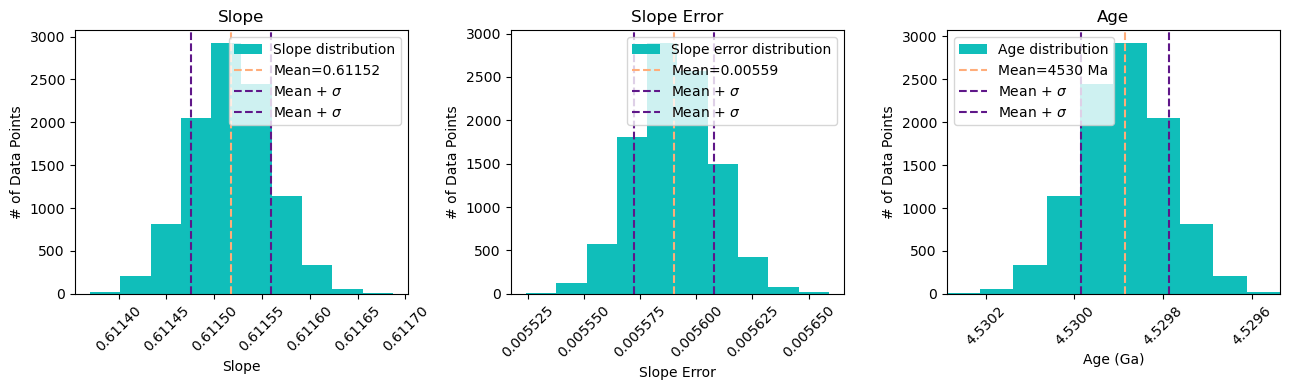

In [20]:
six_err=chondrite_data["206_err"]/2
seven_err=chondrite_data['207_err']/2
mean_64=chondrite_data['206Pb/204Pb']
mean_74=chondrite_data['207Pb/204Pb']
m_arr=[]
m_err_arr=[]
t_arr=[]
for i in range(10000):
    x=[]
    y=[]
    for i in range(len(mean_64)):
        normal_64=np.random.normal(mean_64.iloc[i],six_err.iloc[i],1)
        normal_74=np.random.normal(mean_74.iloc[i],seven_err.iloc[i],1)
        x.append(normal_64[0])
        y.append(normal_74[0])
    m, intercept, r, p, m_err = stats.linregress(x,y)
    m_arr.append(m)
    m_err_arr.append(m_err)
    t = fsolve(decay, guess, args=(m, lambda1, lambda2))
    t_arr.append(t[0])

t_err=np.std(t_arr)
mc_m_err=np.mean(m_err_arr)
m_err_percent_diff=100*(mc_m_err-m_err)/m_err
print(f"Using the Monte Carlo method, the error on the slope is {mc_m_err:.7f}. This means the percent difference between the errors obtained from the two methods is {m_err_percent_diff:.3f}%.")
print(f"The solution for t is: {age[0]*1000:.0f} ± {t_err*1000:.2f} Ma.")

f, a = plt.subplots(1,3, figsize=(13,4))
a[0].hist(m_arr, label="Slope distribution", color="#10beba")
a[0].set_title("Slope")
a[0].set_xlabel("Slope")
a[0].set_ylabel("# of Data Points")
a[0].axvline(x=np.mean(m_arr), color="#ffad7a", linestyle="--", label=f"Mean={np.mean(m_arr):.5f}")
a[0].axvline(x=np.mean(m_arr)+np.std(m_arr), color="#5f1789", linestyle="--", label=r"Mean + $\sigma$")
a[0].axvline(x=np.mean(m_arr)-np.std(m_arr), color="#5f1789", linestyle="--", label=r"Mean + $\sigma$")
a[0].tick_params(axis='x', labelrotation=45)
a[0].legend()
a[1].hist(m_err_arr, label="Slope error distribution", color="#10beba")
a[1].set_title("Slope Error")
a[1].set_xlabel("Slope Error")
a[1].set_ylabel("# of Data Points")
a[1].axvline(x=mc_m_err, color="#ffad7a", linestyle="--", label=f"Mean={mc_m_err:.5f}")
a[1].axvline(x=np.mean(m_err_arr)+np.std(m_err_arr), color="#5f1789", linestyle="--", label=r"Mean + $\sigma$")
a[1].axvline(x=np.mean(m_err_arr)-np.std(m_err_arr), color="#5f1789", linestyle="--", label=r"Mean + $\sigma$")
a[1].tick_params(axis='x', labelrotation=45)
a[1].legend()
a[2].hist(t_arr, label="Age distribution", color="#10beba")
a[2].set_title("Age")
a[2].set_xlabel("Age (Ga)")
a[2].set_ylabel("# of Data Points")
a[2].axvline(x=np.mean(t_arr), color="#ffad7a", linestyle="--", label=f"Mean={np.mean(t_arr)*1000:.0f} Ma")
a[2].axvline(x=np.mean(t_arr)+np.std(t_arr), color="#5f1789", linestyle="--", label=r"Mean + $\sigma$")
a[2].axvline(x=np.mean(t_arr)-np.std(t_arr), color="#5f1789", linestyle="--", label=r"Mean + $\sigma$")
a[2].legend()
a[2].tick_params(axis='x', labelrotation=45)
a[2].set_xlim(np.max(t_arr),np.min(t_arr))
a[2].ticklabel_format(useOffset=False)
plt.tight_layout()
plt.show()

### Conclusion:

The result of the analysis shows that the chondrites that were analyzed have an age of 4530 ± 0.10 Ma. Additionally, the error of the slopes from both the Monte Carlo and stats.lingress() method are very close, with a percent different of only -.407%. This allows for further confidence in the Monte Carlo method for calculating the error of the age of the chondrites. Palk 2018 [5], the paper I retrieve the data from, calculated the ages of difference groups of chondrites, based on their types and locations where they were found. This analysis produced ages in the range of 4497-4568 Ma for the different groups. The mean of these ages is 4532.5 Ma, which matches up quite well with the age I calculated; this makes sense, as I calculated the age using all of the chondrites. The main discrepancy between the age I calculated and the paper is in the error: all the errors in the paper are in the range of 1-280 Ma, which is much bigger than the age error I calculated. The authors of the paper used a program called Isoplot v3.41b to preform the regression of the data and find the slope, age, and errors of the chondrites. I did research on this program, and found that it also uses the Monte Carlo method for calculating error. However, I was not able to identify the cause of the difference between my age error and the paper's. 

Regardless of the error, the result of my analysis produced an age of around 4530 Ma. The oldest ages found in chondrites is around 4568 Ma [7]. This age is found through the analysis of calcium-aluminum inclusions (CAI). CAIs are thought to be the first grains to have formed early in the protoplanetary disk, and therefore their ages correspond to the age of the solar system [8]. CAIs can be seen in the image below [8]:

<img src="cai.png" alt="CAIs" width="500"/>

One possible reason for the younger calculated age is that the data was not collected specifically from CAIs, but rather powder ground down from the chondrites as a whole [5]. This means that other chondrules as well as the matrix of the chondrite, which are younger, may lead to ages that are not actually representative of the age of the solar system. Additionally, the paper describes that some of the data may have come from samples that were contaminated, leading to further error. Regardless, the analysis that I performed above does give a reasonable age, and showcases the way in which isotope ratios can produce the age of a chondrite based on the physics of isotope decay.

### Final Acknowledgments:

I would like to thank Matt for helping me with figuring out different parts of my project, such as how to do the error propogation for the age of the chondrites, as well as teaching the methods I used to do the analysis throughout the course of the semester. I would also like to thank Dr. Eugene Chiang, as I learned the isochron method of radiometric dating in EPS C162. Lastly, thank you to Emeliana Palk and NASA for compiling the datasets that I used in this project.

### References:

[1] Wasson, John T., and Gregory W. Kallemeyn. "Compositions of chondrites." *Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences* 325.1587 (1988): 535-544.
<br>
<br>
[2] Montmerle, T., et al. "Meteorites and the physico-chemical conditions in the early solar nebula." *European Astronomical Society Publications Series* 41 (2010): 253-300. 
<br>
<br>
[3] Bouvier, Audrey, et al. "Pb–Pb dating constraints on the accretion and cooling history of chondrites." *Geochimica et Cosmochimica Acta* 71.6 (2007): 1583-1604
<br>
<br>
[4] NASA. "Meteorite Landings." *Kaggle*, https://www.kaggle.com/datasets/nasa/meteorite-landings?resource=download 
<br>
<br>
[5] Palk, Emeliana, et al. "Variable Tl, Pb, and Cd concentrations and isotope compositions of enstatite and ordinary chondrites—Evidence for volatile element mobilization and decay of extinct 205Pb." *Meteoritics & Planetary Science* 53.2 (2018): 167-186.
<br>
<br>
[6] Nelson, Stephon A. "Radiometric Dating." *Tulane University*, (2012), https://www2.tulane.edu/~sanelson/eens212/radiometric_dating.htm 
<br>
<br>
[7] Bouvier, Audrey, and Meenakshi Wadhwa. "The age of the Solar System redefined by the oldest Pb–Pb age of a meteoritic inclusion." Nature geoscience 3.9 (2010): 637-641
<br>
<br>
[8] Charnoz, Sébastien, et al. "Growth of calcium–aluminum-rich inclusions by coagulation and fragmentation in a turbulent protoplanetary disk: Observations and simulations." Icarus 252 (2015): 440-453.